<a href="https://colab.research.google.com/github/cmugruza/Vaccine_Deaths_Sunampe/blob/main/Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The primary analysis focused on identifying factors associated with the binary outcome of whether a child's vaccination with other variables. Logistic regression analysis was employed to model the relationship between various parental concerns and access barriers (independent variables) and this vaccination outcome (dependent variable).

Prior to conducting the logistic regression, the dataset was pre-processed to handle missing values. Numerical variables were imputed with the mean, and categorical variables with the mode. To address potential issues of perfect separation or quasi-separation, which can lead to unstable model estimates, a thorough examination of the relationship between each predictor variable and the outcome variable was conducted using cross-tabulations and frequency counts. Predictor variables exhibiting perfect or near-perfect prediction of the outcome were excluded from the logistic regression model to ensure model stability and interpretability.

The final logistic regression model's coefficients, standard errors, p-values, and odds ratios were examined to determine the strength and direction of the associations between the independent variables and the likelihood of other variables. Model performance was assessed using metrics such as the classification report, confusion matrix, and Receiver Operating Characteristic (ROC) curve with the Area Under the Curve (AUC). Statistical analyses were performed using the pandas, numpy, and statsmodels libraries in Python.


--- Checking for Potential Separation (Value Counts) ---

Value counts for predictor 'Q01':
Q01
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q25' where 'Q01' has each value:
  Value '1':
Q25
0    102
1     20
Name: count, dtype: int64
  Value '0':
Q25
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q01' for value '0'.

Value counts for predictor 'Q02':
Q02
1    62
0    61
Name: count, dtype: int64

Value counts for target 'Q25' where 'Q02' has each value:
  Value '0':
Q25
0    54
1     7
Name: count, dtype: int64
  Value '1':
Q25
0    49
1    13
Name: count, dtype: int64

Value counts for predictor 'Q03':
Q03
1    78
0    45
Name: count, dtype: int64

Value counts for target 'Q25' where 'Q03' has each value:
  Value '0':
Q25
0    40
1     5
Name: count, dtype: int64
  Value '1':
Q25
0    63
1    15
Name: count, dtype: int64

Value counts for predictor 'Q04':
Q04
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q25' wher

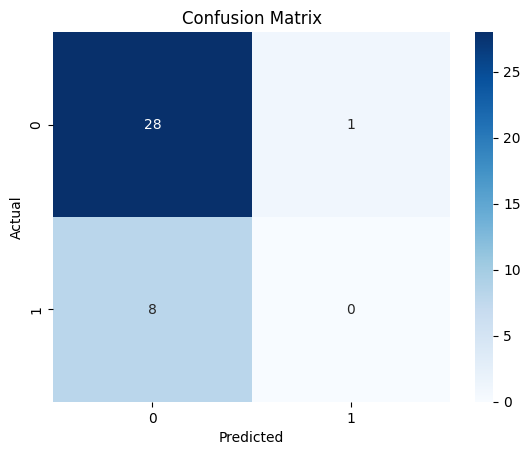

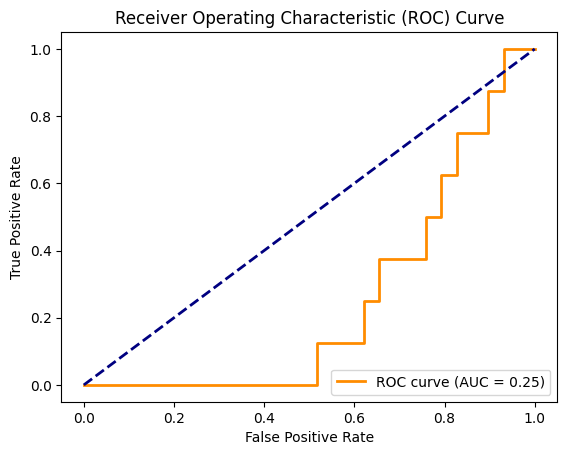


Model Coefficients:
     Variable  Coefficient
0   Intercept   -22.479499
1    Q('Q02')    -0.522736
2    Q('Q03')     0.564729
3    Q('Q04')     0.044405
4    Q('Q05')     0.002444
5    Q('Q07')    -0.530825
6    Q('Q09')     1.712390
7    Q('Q10')     0.098251
8    Q('Q11')    -0.182646
9    Q('Q12')    20.704135
10   Q('Q13')     2.874714
11   Q('Q14')    -1.255624
12   Q('Q17')    -0.655672
13   Q('Q18')     0.962259
14   Q('Q19')    -1.455987
15   Q('Q22')     0.115096


In [22]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()  # Select rows 1 to 124 (index 0 to 122) and create a copy
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor and target variables
predictor_columns_initial = df.columns[5:31]
target_column = 'Q25'#
if target_column not in df.columns:
    print(f"Error: Target column '{target_column}' not found.")
    exit()
X_initial = df[predictor_columns_initial].copy()
y = pd.to_numeric(df[target_column].copy(), errors='coerce')

# --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
problematic_predictors = []
print("\n--- Checking for Potential Separation (Value Counts) ---")
for col in X_initial.columns:
    print(f"\nValue counts for predictor '{col}':")
    print(X_initial[col].value_counts(dropna=False))
    print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
    for val in X_initial[col].unique():
        subset_y = y[X_initial[col] == val]
        print(f"  Value '{val}':")
        print(subset_y.value_counts(dropna=False))
        if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
            if col not in problematic_predictors:
                problematic_predictors.append(col)
                print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

print("\nPotentially problematic predictors:", problematic_predictors)

# Update predictor columns by removing the problematic ones
predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
X = X_initial[predictor_columns_final].copy()

# Handle missing values
for col in X.select_dtypes(include=np.number).columns:
    X.loc[:, col] = X[col].fillna(X[col].mean())
for col in X.select_dtypes(include='object').columns:
    try:
        X.loc[:, col] = X[col].fillna(X[col].mode()[0])
    except IndexError:
        print(f"Warning: Cannot impute missing for categorical column '{col}'.")
if y.isnull().any():
    print("Warning: Missing values in target. Imputing with mode.")
    try:
        y = y.fillna(y.mode()[0])
        y = pd.to_numeric(y)
    except IndexError:
        print("Error: Cannot impute missing in target (no mode).")
        exit()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check for all NaN columns
nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
X_train = X_train[predictor_columns_final_train]
X_test = X_test[predictor_columns_final_train]

# Build and fit the model
if predictor_columns_final_train:
    formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" for col in predictor_columns_final_train])
    try:
        model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
        result = model.fit()

        # Print the model summary and evaluate
        print(result.summary())

        y_pred_proba = result.predict(X_test)
        y_pred = (y_pred_proba > 0.5).astype(int)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        coefficients = pd.DataFrame({'Variable': result.params.index, 'Coefficient': result.params.values})
        print("\nModel Coefficients:")
        print(coefficients)

        # Visualization
        # ... (rest of your visualization code) ...

    except Exception as e:
        print(f"An error occurred during model fitting or evaluation: {e}")
else:
    print("Error: No predictor columns available to build the model.")

Se han truncado las últimas 5000 líneas del flujo de salida.
                             ^^^^^^^^^

--- Checking for Potential Separation (Value Counts) for target: Q10 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q10' where 'Sex' has each value:
  Value '0':
Q10
1    43
0    23
Name: count, dtype: int64
  Value '1':
Q10
1    34
0    23
Name: count, dtype: int64

Value counts for predictor 'Age':
Age
1    32
4    29
0    24
3    21
2    17
Name: count, dtype: int64

Value counts for target 'Q10' where 'Age' has each value:
  Value '3':
Q10
1    19
0     2
Name: count, dtype: int64
  Value '1':
Q10
1    20
0    12
Name: count, dtype: int64
  Value '2':
Q10
1    9
0    8
Name: count, dtype: int64
  Value '4':
Q10
0    16
1    13
Name: count, dtype: int64
  Value '0':
Q10
1    16
0     8
Name: count, dtype: int64

Value counts for predictor 'Insurance':
Insurance
0    115
1      7
2      1
Name: count, dtype: int64

Value 

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               Q('Q15')   No. Observations:                   86
Model:                            GLM   Df Residuals:                       73
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.8581e-09
Date:                Fri, 11 Apr 2025   Deviance:                   3.7163e-09
Time:                        15:04:09   Pearson chi2:                 1.86e-09
No. Iterations:                    25   Pseudo R-squ. (CS):             0.2611
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.1487   1.02e+05      0.001      0.9

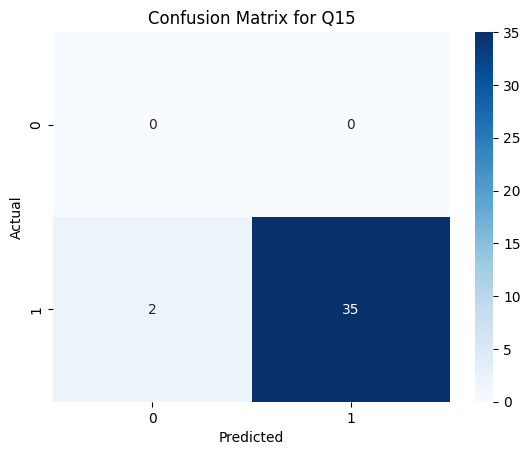

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


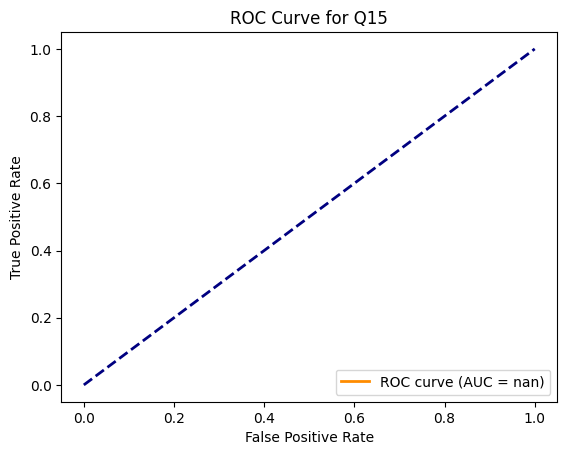


Model Coefficients:
     Variable  Coefficient
0   Intercept    66.148679
1    Q('Q02')   -42.689375
2    Q('Q03')    86.933032
3    Q('Q04')   -44.337152
4    Q('Q05')   -40.207573
5    Q('Q07')     2.801232
6    Q('Q08')    45.547782
7    Q('Q10')   -44.348660
8    Q('Q14')    40.724354
9    Q('Q17')     0.838011
10   Q('Q18')    -2.481234
11   Q('Q20')  -136.149580
12   Q('Q24')   -46.493550

Logistic Regression Equation for Q15:
Logit(Q15) = 66.1487 +
 -42.6894 * Q02 +
 86.9330 * Q03 +
 -44.3372 * Q04 +
 -40.2076 * Q05 +
 2.8012 * Q07 +
 45.5478 * Q08 +
 -44.3487 * Q10 +
 40.7244 * Q14 +
 0.8380 * Q17 +
 -2.4812 * Q18 +
 -136.1496 * Q20 +
 -46.4935 * Q24 +

--- Checking for Potential Separation (Value Counts) for target: Q16 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q16' where 'Sex' has each value:
  Value '0':
Q16
0    66
Name: count, dtype: int64
    Potential perfect prediction by 'Sex' for value '0'.
  Value 

<ipython-input-16-10e3ded0a950>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Logit({target_column}) = {result.params[0]:.4f} +")
<ipython-input-16-10e3ded0a950>:150: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col} +")


Q17
0    3
1    3
Name: count, dtype: int64
  Value '33':
Q17
1    3
Name: count, dtype: int64
  Value '27':
Q17
0    2
1    1
Name: count, dtype: int64
  Value '24':
Q17
1    6
0    5
Name: count, dtype: int64
  Value '31':
Q17
1    4
Name: count, dtype: int64
  Value '29':
Q17
1    4
0    2
Name: count, dtype: int64
  Value '30':
Q17
0    6
1    2
Name: count, dtype: int64
  Value '25':
Q17
1    3
0    3
Name: count, dtype: int64
  Value '21':
Q17
0    4
1    3
Name: count, dtype: int64
  Value '38':
Q17
1    1
0    1
Name: count, dtype: int64
  Value '43':
Q17
1    1
Name: count, dtype: int64
  Value '20':
Q17
1    2
0    2
Name: count, dtype: int64
  Value '41':
Q17
1    1
Name: count, dtype: int64
  Value '23':
Q17
1    3
0    2
Name: count, dtype: int64
  Value '39':
Q17
0    2
1    1
Name: count, dtype: int64
  Value '45':
Q17
1    2
Name: count, dtype: int64
  Value '37':
Q17
0    2
1    1
Name: count, dtype: int64
  Value '46':
Q17
1    1
Name: count, dtype: int64
  Value '42'

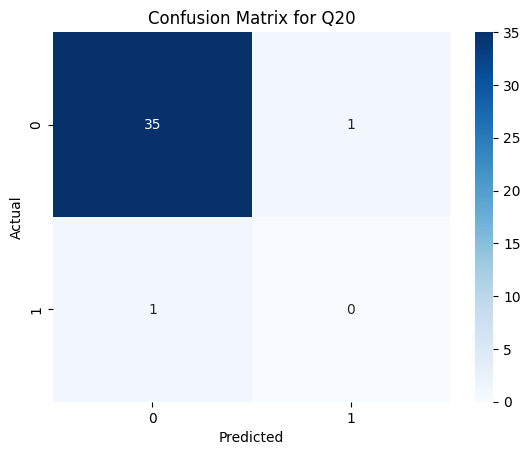

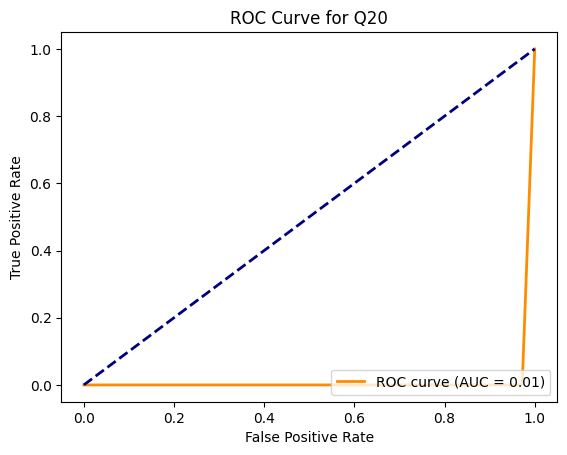


Model Coefficients:
       Variable  Coefficient
0     Intercept    -0.953215
1   C(Sex)[T.1]    -0.295436
2      Q('Q02')     0.734453
3      Q('Q04')   -20.888521
4      Q('Q05')    -0.268614
5      Q('Q07')     1.694671
6      Q('Q14')    21.504384
7      Q('Q15')    -2.569548
8      Q('Q17')    -1.174478
9      Q('Q18')    -0.429918
10     Q('Q19')   -39.889163

Logistic Regression Equation for Q20:
Logit(Q20) = -0.9532 +
 -0.2954 * Sex_1 +
 0.7345 * Q02 +
 -20.8885 * Q04 +
 -0.2686 * Q05 +
 1.6947 * Q07 +
 21.5044 * Q14 +
 -2.5695 * Q15 +
 -1.1745 * Q17 +
 -0.4299 * Q18 +
 -39.8892 * Q19 +

--- Checking for Potential Separation (Value Counts) for target: Q21 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q21' where 'Sex' has each value:
  Value '0':
Q21
1    65
0     1
Name: count, dtype: int64
  Value '1':
Q21
1    57
Name: count, dtype: int64
    Potential perfect prediction by 'Sex' for value '1'.

Value counts fo

<ipython-input-16-10e3ded0a950>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Logit({target_column}) = {result.params[0]:.4f} +")
<ipython-input-16-10e3ded0a950>:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col}_{val} +")
<ipython-input-16-10e3ded0a950>:150: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col} +")


    Potential perfect prediction by 'Insurance' for value '2'.

Value counts for predictor 'AgeMother':
AgeMother
24    11
26     8
30     8
34     7
28     7
21     7
25     6
29     6
22     6
35     5
23     5
19     4
36     4
32     4
31     4
20     4
18     4
37     3
27     3
33     3
39     3
42     2
38     2
45     2
0      1
43     1
41     1
46     1
2      1
Name: count, dtype: int64

Value counts for target 'Q22' where 'AgeMother' has each value:
  Value '26':
Q22
0    4
1    4
Name: count, dtype: int64
  Value '19':
Q22
0    3
1    1
Name: count, dtype: int64
  Value '28':
Q22
1    6
0    1
Name: count, dtype: int64
  Value '32':
Q22
1    3
0    1
Name: count, dtype: int64
  Value '36':
Q22
0    3
1    1
Name: count, dtype: int64
  Value '34':
Q22
1    4
0    3
Name: count, dtype: int64
  Value '18':
Q22
0    3
1    1
Name: count, dtype: int64
  Value '35':
Q22
0    3
1    2
Name: count, dtype: int64
  Value '0':
Q22
1    1
Name: count, dtype: int64
    Potential perfec

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


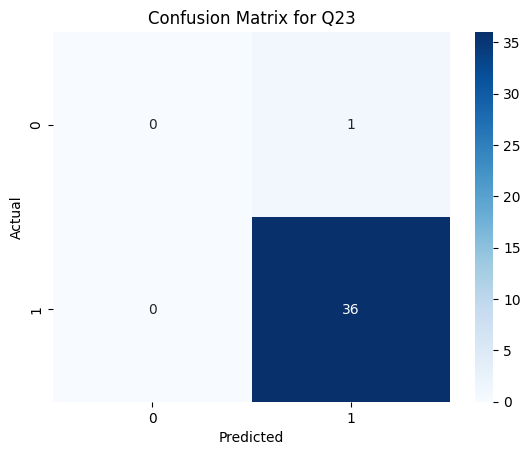

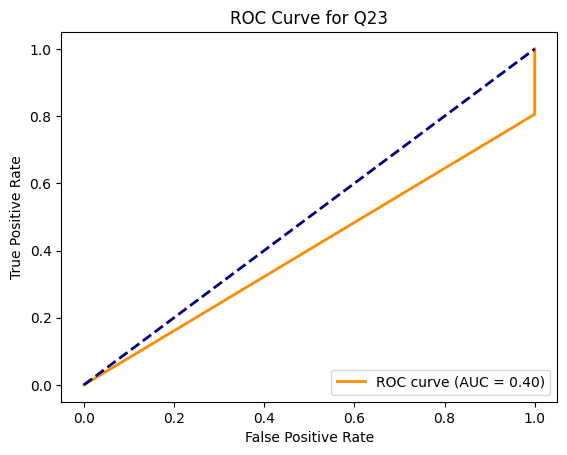


Model Coefficients:
      Variable  Coefficient
0    Intercept   130.524902
1  C(Sex)[T.1]    21.087738
2     Q('Q04')    22.274916
3     Q('Q07')    20.462594
4     Q('Q11')  -106.687933
5     Q('Q12')  -107.476950
6     Q('Q14')   -63.602865
7     Q('Q17')   107.448051
8     Q('Q22')   -21.661658
9     Q('Q24')    20.267139

Logistic Regression Equation for Q23:
Logit(Q23) = 130.5249 +
 21.0877 * Sex_1 +
 22.2749 * Q04 +
 20.4626 * Q07 +
 -106.6879 * Q11 +
 -107.4770 * Q12 +
 -63.6029 * Q14 +
 107.4481 * Q17 +
 -21.6617 * Q22 +
 20.2671 * Q24 +

--- Checking for Potential Separation (Value Counts) for target: Q24 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q24' where 'Sex' has each value:
  Value '0':
Q24
0    61
1     5
Name: count, dtype: int64
  Value '1':
Q24
0    55
1     2
Name: count, dtype: int64

Value counts for predictor 'Age':
Age
1    32
4    29
0    24
3    21
2    17
Name: count, dtype: int64

Value co

<ipython-input-16-10e3ded0a950>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Logit({target_column}) = {result.params[0]:.4f} +")
<ipython-input-16-10e3ded0a950>:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col}_{val} +")
<ipython-input-16-10e3ded0a950>:150: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col} +")
/usr/local/lib/

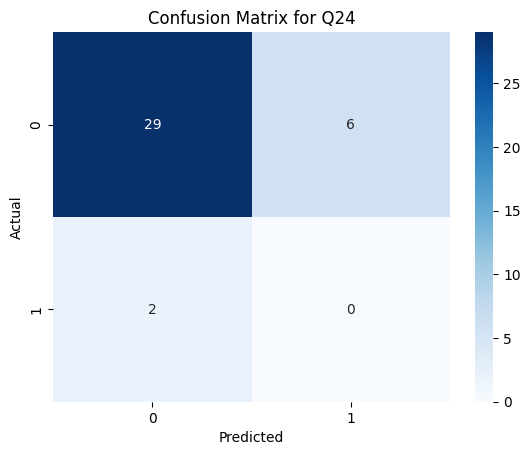

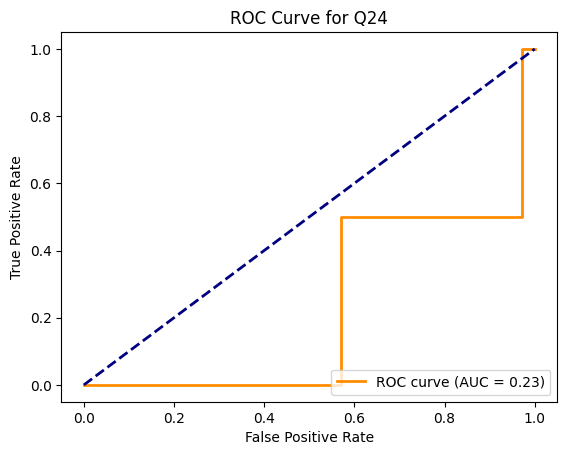


Model Coefficients:
       Variable  Coefficient
0     Intercept   138.766483
1   C(Sex)[T.1]    -8.169078
2      Q('Q02')    12.352967
3      Q('Q03')  -117.242709
4      Q('Q04')   -94.947652
5      Q('Q05')   -19.233878
6      Q('Q07')   -18.881151
7      Q('Q08')   -30.517577
8      Q('Q09')  -172.194014
9      Q('Q10')    49.482945
10     Q('Q11')    21.087601
11     Q('Q14')   236.776124
12     Q('Q15')  -105.788580
13     Q('Q17')    49.455528
14     Q('Q18')   -30.560044
15     Q('Q19')   119.195909
16     Q('Q22')   -59.993179
17     Q('Q23')   -88.014968

Logistic Regression Equation for Q24:
Logit(Q24) = 138.7665 +
 -8.1691 * Sex_1 +
 12.3530 * Q02 +
 -117.2427 * Q03 +
 -94.9477 * Q04 +
 -19.2339 * Q05 +
 -18.8812 * Q07 +
 -30.5176 * Q08 +
 -172.1940 * Q09 +
 49.4829 * Q10 +
 21.0876 * Q11 +
 236.7761 * Q14 +
 -105.7886 * Q15 +
 49.4555 * Q17 +
 -30.5600 * Q18 +
 119.1959 * Q19 +
 -59.9932 * Q22 +
 -88.0150 * Q23 +

--- Checking for Potential Separation (Value Counts) for t

<ipython-input-16-10e3ded0a950>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Logit({target_column}) = {result.params[0]:.4f} +")
<ipython-input-16-10e3ded0a950>:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col}_{val} +")
<ipython-input-16-10e3ded0a950>:150: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col} +")
/usr/local/lib/

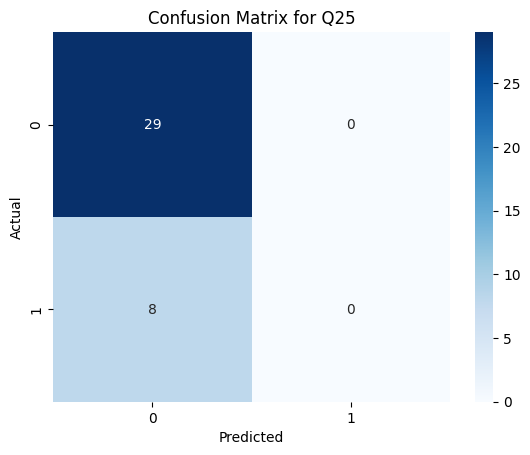

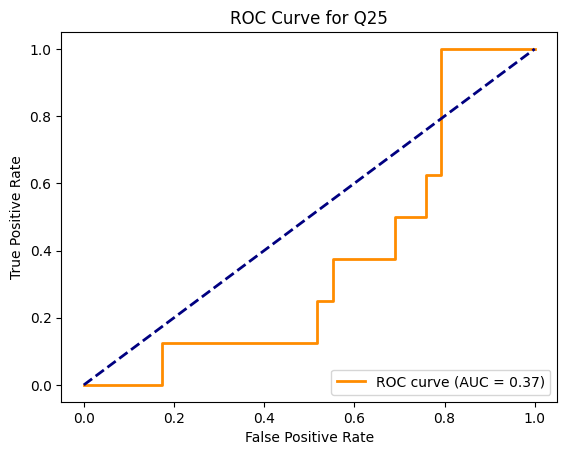


Model Coefficients:
       Variable  Coefficient
0     Intercept   -23.887208
1   C(Sex)[T.1]     1.930664
2   C(Age)[T.1]    -1.760179
3   C(Age)[T.2]   -23.765471
4   C(Age)[T.3]    -1.699180
5   C(Age)[T.4]    -3.993978
6      Q('Q02')    -0.327901
7      Q('Q03')     0.539826
8      Q('Q04')     0.482735
9      Q('Q05')     1.319781
10     Q('Q07')    -2.509598
11     Q('Q09')     1.824180
12     Q('Q10')    -0.213846
13     Q('Q11')     1.802969
14     Q('Q12')    22.335104
15     Q('Q13')     3.760185
16     Q('Q14')    -1.110858
17     Q('Q17')    -1.077189
18     Q('Q18')     0.498956
19     Q('Q19')    -1.506408
20     Q('Q22')     0.995004

Logistic Regression Equation for Q25:
Logit(Q25) = -23.8872 +
 1.9307 * Sex_1 +
 -1.7602 * Age_0 +
 -23.7655 * Age_3 +
 -1.6992 * Age_1 +
 -3.9940 * Age_2 +
 -0.3279 * Q02 +
 0.5398 * Q03 +
 0.4827 * Q04 +
 1.3198 * Q05 +
 -2.5096 * Q07 +
 1.8242 * Q09 +
 -0.2138 * Q10 +
 1.8030 * Q11 +
 22.3351 * Q12 +
 3.7602 * Q13 +
 -1.1109 * Q14 +
 -

<ipython-input-16-10e3ded0a950>:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Logit({target_column}) = {result.params[0]:.4f} +")
<ipython-input-16-10e3ded0a950>:147: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col}_{val} +")
<ipython-input-16-10e3ded0a950>:150: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f" {result.params[coef_index]:.4f} * {col} +")


In [16]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor columns
predictor_columns_initial = df.columns[0:31]

# Target columns (Q01 to Q25)
target_columns = [f'Q{i:02d}' for i in range(1, 26)]

# Analyze each target column
for target_column in target_columns:
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found.")
        continue

    y = pd.to_numeric(df[target_column].copy(), errors='coerce')
    X_initial = df[predictor_columns_initial].copy()

    # --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
    problematic_predictors = []
    print(f"\n--- Checking for Potential Separation (Value Counts) for target: {target_column} ---")
    for col in X_initial.columns:
        print(f"\nValue counts for predictor '{col}':")
        print(X_initial[col].value_counts(dropna=False))
        print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
        for val in X_initial[col].unique():
            subset_y = y[X_initial[col] == val]
            print(f"  Value '{val}':")
            print(subset_y.value_counts(dropna=False))
            if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
                if col not in problematic_predictors:
                    problematic_predictors.append(col)
                    print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

    print("\nPotentially problematic predictors:", problematic_predictors)

    # Update predictor columns by removing the problematic ones
    predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
    X = X_initial[predictor_columns_final].copy()

    # Handle missing values
    for col in X.select_dtypes(include=np.number).columns:
        X.loc[:, col] = X[col].fillna(X[col].mean())
    for col in X.select_dtypes(include='object').columns:
        try:
            X.loc[:, col] = X[col].fillna(X[col].mode()[0])
            X.loc[:, col] = X[col].astype('category')
        except IndexError:
            print(f"Warning: Cannot impute missing for categorical column '{col}'.")
    if y.isnull().any():
        print("Warning: Missing values in target. Imputing with mode.")
        try:
            y = y.fillna(y.mode()[0])
            y = pd.to_numeric(y)
        except IndexError:
            print("Error: Cannot impute missing in target (no mode).")
            continue

    # Convert 'Sex' to category before splitting
    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Check for all NaN columns
    nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
    predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
    X_train = X_train[predictor_columns_final_train]
    X_test = X_test[predictor_columns_final_train]

    # Align the indices of X_train and y_train
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]

    # Debugging: Print lengths, data types, and unique values of Age
    print(f"\nLength of X_train: {len(X_train)}")
    print(f"Length of y_train: {len(y_train)}")
    print(f"Length of X_test: {len(X_test)}")
    print(f"Length of y_test: {len(y_test)}")
    print(f"\nData types of X_train:\n{X_train.dtypes}")
    print(f"\nUnique values of Age in X_train: {X_train['Age'].unique() if 'Age' in X_train else 'Age column not found'}")
    print(f"\nNull values in Age in X_train: {X_train['Age'].isnull().sum() if 'Age' in X_train else 'Age column not found'}")
    print(f"\nColumns in X_train: {X_train.columns.tolist()}")

    # Build and fit the model
    if predictor_columns_final_train:
        formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" if 'Q' in col else f"C({col})" if col in ['Sex', 'Age'] else f"'{col}'" for col in predictor_columns_final_train])
        try:
            model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
            result = model.fit()

            # Print the model summary and evaluate
            print(result.summary())

            y_pred_proba = result.predict(X_test)
            y_pred = (y_pred_proba > 0.5).astype(int)

            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            conf_matrix = confusion_matrix(y_test, y_pred)
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix for {target_column}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            roc_auc = roc_auc_score(y_test, y_pred_proba)
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve for {target_column}')
            plt.legend(loc='lower right')
            plt.show()

            coefficients = pd.DataFrame({'Variable': result.params.index, 'Coefficient': result.params.values})
            print("\nModel Coefficients:")
            print(coefficients)

            # Report Logistic Equation
            print(f"\nLogistic Regression Equation for {target_column}:")
            print(f"Logit({target_column}) = {result.params[0]:.4f} +")
            coef_index = 1
            for col in predictor_columns_final_train:
                if col in ['Sex', 'Age']:
                    unique_vals = X_train[col].unique()
                    for val in unique_vals[1:]: # Skip the first value
                        print(f" {result.params[coef_index]:.4f} * {col}_{val} +")
                        coef_index += 1
                else:
                    print(f" {result.params[coef_index]:.4f} * {col} +")
                    coef_index += 1

        except Exception as e:
            print(f"An error occurred during model fitting or evaluation for {target_column}: {e}")
    else:
        print(f"Error: No predictor columns available to build the model for {target_column}.")

In [17]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor columns
predictor_columns_initial = df.columns[0:31]

# Target columns (Q01 to Q25)
target_columns = [f'Q{i:02d}' for i in range(1, 26)]

# List to store model results
model_results = []

# Analyze each target column
for target_column in target_columns:
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found.")
        continue

    y = pd.to_numeric(df[target_column].copy(), errors='coerce')
    X_initial = df[predictor_columns_initial].copy()

    # --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
    problematic_predictors = []
    print(f"\n--- Checking for Potential Separation (Value Counts) for target: {target_column} ---")
    for col in X_initial.columns:
        print(f"\nValue counts for predictor '{col}':")
        print(X_initial[col].value_counts(dropna=False))
        print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
        for val in X_initial[col].unique():
            subset_y = y[X_initial[col] == val]
            print(f"  Value '{val}':")
            print(subset_y.value_counts(dropna=False))
            if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
                if col not in problematic_predictors:
                    problematic_predictors.append(col)
                    print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

    print("\nPotentially problematic predictors:", problematic_predictors)

    # Update predictor columns by removing the problematic ones
    predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
    X = X_initial[predictor_columns_final].copy()

    # Handle missing values
    for col in X.select_dtypes(include=np.number).columns:
        X.loc[:, col] = X[col].fillna(X[col].mean())
    for col in X.select_dtypes(include='object').columns:
        try:
            X.loc[:, col] = X[col].fillna(X[col].mode()[0])
            X.loc[:, col] = X[col].astype('category')
        except IndexError:
            print(f"Warning: Cannot impute missing for categorical column '{col}'.")
    if y.isnull().any():
        print("Warning: Missing values in target. Imputing with mode.")
        try:
            y = y.fillna(y.mode()[0])
            y = pd.to_numeric(y)
        except IndexError:
            print("Error: Cannot impute missing in target (no mode).")
            continue

    # Convert 'Sex' to category before splitting
    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Check for all NaN columns
    nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
    predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
    X_train = X_train[predictor_columns_final_train]
    X_test = X_test[predictor_columns_final_train]

    # Align the indices of X_train and y_train
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]

    # Build and fit the model
    if predictor_columns_final_train:
        formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" if 'Q' in col else f"C({col})" if col in ['Sex', 'Age'] else f"'{col}'" for col in predictor_columns_final_train])
        try:
            model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
            result = model.fit()

            # Calculate AUC
            y_pred_proba = result.predict(X_test)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Store model results
            model_results.append({
                'Target': target_column,
                'AIC': result.aic,
                'AUC': roc_auc,
                'Coefficients': result.params,
                'P-values': result.pvalues
            })

        except Exception as e:
            print(f"An error occurred during model fitting or evaluation for {target_column}: {e}")
    else:
        print(f"Error: No predictor columns available to build the model for {target_column}.")

# Create DataFrame from model results
results_df = pd.DataFrame(model_results)

# Print results table
print("\nTabla 1: Resultados de Regresión Logística")
print(results_df[['Target', 'AIC', 'AUC']])

# Find the best model based on AIC and AUC
best_model = results_df.loc[results_df['AUC'].idxmax()] #choose by AUC.
print(f"\nEl mejor modelo es para {best_model['Target']}.")

# Print significant variables for the best model
significant_vars = best_model['P-values'][best_model['P-values'] < 0.05].index.tolist()
print(f"Variables predictoras significativas: {significant_vars}")

Se han truncado las últimas 5000 líneas del flujo de salida.
1    52
0    35
Name: count, dtype: int64
  Value '1':
Q10
1    25
0    11
Name: count, dtype: int64

Value counts for predictor 'Q19':
Q19
0    78
1    45
Name: count, dtype: int64

Value counts for target 'Q10' where 'Q19' has each value:
  Value '0':
Q10
1    50
0    28
Name: count, dtype: int64
  Value '1':
Q10
1    27
0    18
Name: count, dtype: int64

Value counts for predictor 'Q20':
Q20
0    119
1      4
Name: count, dtype: int64

Value counts for target 'Q10' where 'Q20' has each value:
  Value '0':
Q10
1    77
0    42
Name: count, dtype: int64
  Value '1':
Q10
0    4
Name: count, dtype: int64
    Potential perfect prediction by 'Q20' for value '1'.

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q10' where 'Q21' has each value:
  Value '1':
Q10
1    77
0    45
Name: count, dtype: int64
  Value '0':
Q10
0    1
Name: count, dtype: int64
    Potential perfect

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.

Value counts for target 'Q19' where 'Q19' has each value:
  Value '0':
Q19
0    78
Name: count, dtype: int64
    Potential perfect prediction by 'Q19' for value '0'.
  Value '1':
Q19
1    45
Name: count, dtype: int64

Value counts for predictor 'Q20':
Q20
0    119
1      4
Name: count, dtype: int64

Value counts for target 'Q19' where 'Q20' has each value:
  Value '0':
Q19
0    75
1    44
Name: count, dtype: int64
  Value '1':
Q19
0    3
1    1
Name: count, dtype: int64

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q19' where 'Q21' has each value:
  Value '1':
Q19
0    77
1    45
Name: count, dtype: int64
  Value '0':
Q19
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q21' for value '0'.

Value counts for predictor 'Q22':
Q22
1    68
0    55
Name: count, dtype: int64

Value counts for target 'Q19' where 'Q22' has each value:
  Value '0':
Q1

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor columns
predictor_columns_initial = df.columns[0:31]

# Target columns (Q01 to Q25)
target_columns = [f'Q{i:02d}' for i in range(1, 26)]

# List to store model results
model_results = []

# Analyze each target column
for target_column in target_columns:
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found.")
        continue

    y = pd.to_numeric(df[target_column].copy(), errors='coerce')
    X_initial = df[predictor_columns_initial].copy()

    # --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
    problematic_predictors = []
    print(f"\n--- Checking for Potential Separation (Value Counts) for target: {target_column} ---")
    for col in X_initial.columns:
        print(f"\nValue counts for predictor '{col}':")
        print(X_initial[col].value_counts(dropna=False))
        print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
        for val in X_initial[col].unique():
            subset_y = y[X_initial[col] == val]
            print(f"  Value '{val}':")
            print(subset_y.value_counts(dropna=False))
            if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
                if col not in problematic_predictors:
                    problematic_predictors.append(col)
                    print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

    print("\nPotentially problematic predictors:", problematic_predictors)

    # Update predictor columns by removing the problematic ones
    predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
    X = X_initial[predictor_columns_final].copy()

    # Handle missing values
    for col in X.select_dtypes(include=np.number).columns:
        X.loc[:, col] = X[col].fillna(X[col].mean())
    for col in X.select_dtypes(include='object').columns:
        try:
            X.loc[:, col] = X[col].fillna(X[col].mode()[0])
            X.loc[:, col] = X[col].astype('category')
        except IndexError:
            print(f"Warning: Cannot impute missing for categorical column '{col}'.")
    if y.isnull().any():
        print("Warning: Missing values in target. Imputing with mode.")
        try:
            y = y.fillna(y.mode()[0])
            y = pd.to_numeric(y)
        except IndexError:
            print("Error: Cannot impute missing in target (no mode).")
            continue

    # Convert 'Sex' to category before splitting
    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Check for all NaN columns
    nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
    predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
    X_train = X_train[predictor_columns_final_train]
    X_test = X_test[predictor_columns_final_train]

    # Align the indices of X_train and y_train
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]

    # Build and fit the model
    if predictor_columns_final_train:
        formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" if 'Q' in col else f"C({col})" if col in ['Sex', 'Age'] else f"'{col}'" for col in predictor_columns_final_train])
        try:
            model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
            result = model.fit()

            # Calculate AUC
            y_pred_proba = result.predict(X_test)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Store model results
            model_results.append({
                'Target': target_column,
                'AIC': result.aic,
                'AUC': roc_auc,
                'Coefficients': result.params,
                'P-values': result.pvalues
            })

        except Exception as e:
            print(f"Warning: Model fitting failed for {target_column}: {e}")
            model_results.append({
                'Target': target_column,
                'AIC': np.nan,
                'AUC': np.nan,
                'Coefficients': None,
                'P-values': None
            })

    else:
        print(f"Warning: No predictor columns available to build the model for {target_column}.")
        model_results.append({
            'Target': target_column,
            'AIC': np.nan,
            'AUC': np.nan,
            'Coefficients': None,
            'P-values': None
        })

# Create DataFrame from model results
results_df = pd.DataFrame(model_results)

# Print results table
print("\nTabla 1: Resultados de Regresión Logística")
print(results_df[['Target', 'AIC', 'AUC']])

# Find the best model based on AIC and AUC
best_model = results_df.loc[results_df['AUC'].idxmax()] #choose by AUC.
print(f"\nEl mejor modelo es para {best_model['Target']}.")

# Print significant variables for the best model
significant_vars = best_model['P-values'][best_model['P-values'] < 0.05].index.tolist()
print(f"Variables predictoras significativas: {significant_vars}")

Se han truncado las últimas 5000 líneas del flujo de salida.
1    2
Name: count, dtype: int64
  Value '39':
Q10
1    2
0    1
Name: count, dtype: int64
  Value '45':
Q10
1    1
0    1
Name: count, dtype: int64
  Value '37':
Q10
0    2
1    1
Name: count, dtype: int64
  Value '46':
Q10
0    1
Name: count, dtype: int64
  Value '42':
Q10
1    2
Name: count, dtype: int64
  Value '2':
Q10
1    1
Name: count, dtype: int64

Value counts for predictor 'Married':
Married
2    61
1    49
0    13
Name: count, dtype: int64

Value counts for target 'Q10' where 'Married' has each value:
  Value '1':
Q10
1    30
0    19
Name: count, dtype: int64
  Value '2':
Q10
1    38
0    23
Name: count, dtype: int64
  Value '0':
Q10
1    9
0    4
Name: count, dtype: int64

Value counts for predictor 'Q01':
Q01
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q10' where 'Q01' has each value:
  Value '1':
Q10
1    77
0    45
Name: count, dtype: int64
  Value '0':
Q10
0    1
Name: count, dtype: 

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
Q19
0    78
1    45
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q19' has each value:
  Value '0':
Q18
0    59
1    19
Name: count, dtype: int64
  Value '1':
Q18
0    28
1    17
Name: count, dtype: int64

Value counts for predictor 'Q20':
Q20
0    119
1      4
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q20' has each value:
  Value '0':
Q18
0    84
1    35
Name: count, dtype: int64
  Value '1':
Q18
0    3
1    1
Name: count, dtype: int64

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q21' has each value:
  Value '1':
Q18
0    86
1    36
Name: count, dtype: int64
  Value '0':
Q18
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q21' for value '0'.

Value counts for predictor 'Q22':
Q22
1    68
0    55
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q22' has each value:
  Value '0

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)



--- Checking for Potential Separation (Value Counts) for target: Q25 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q25' where 'Sex' has each value:
  Value '0':
Q25
0    57
1     9
Name: count, dtype: int64
  Value '1':
Q25
0    46
1    11
Name: count, dtype: int64

Value counts for predictor 'Age':
Age
1    32
4    29
0    24
3    21
2    17
Name: count, dtype: int64

Value counts for target 'Q25' where 'Age' has each value:
  Value '3':
Q25
0    16
1     5
Name: count, dtype: int64
  Value '1':
Q25
0    27
1     5
Name: count, dtype: int64
  Value '2':
Q25
0    16
1     1
Name: count, dtype: int64
  Value '4':
Q25
0    25
1     4
Name: count, dtype: int64
  Value '0':
Q25
0    19
1     5
Name: count, dtype: int64

Value counts for predictor 'Insurance':
Insurance
0    115
1      7
2      1
Name: count, dtype: int64

Value counts for target 'Q25' where 'Insurance' has each value:
  Value '1':
Q25
0    7
Name: count, dty

In [20]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

# Load data (explicitly selecting rows 1 to 124)
try:
    df = pd.read_excel('Dataset.Sunampe.Vaccine.xlsx', header=0)
    df = df.iloc[0:123].copy()
except FileNotFoundError:
    print("Error: The file 'Dataset.Sunampe.Vaccine.xlsx' was not found.")
    exit()

# Select predictor columns
predictor_columns_initial = df.columns[0:31]

# Target columns (Q01 to Q25)
target_columns = [f'Q{i:02d}' for i in range(1, 26)]

# List to store model results
model_results = []

# Analyze each target column
for target_column in target_columns:
    if target_column not in df.columns:
        print(f"Error: Target column '{target_column}' not found.")
        continue

    y = pd.to_numeric(df[target_column].copy(), errors='coerce')
    X_initial = df[predictor_columns_initial].copy()

    # --- AGGRESSIVE CHECK FOR PERFECT SEPARATION ---
    problematic_predictors = []
    print(f"\n--- Checking for Potential Separation (Value Counts) for target: {target_column} ---")
    for col in X_initial.columns:
        print(f"\nValue counts for predictor '{col}':")
        print(X_initial[col].value_counts(dropna=False))
        print(f"\nValue counts for target '{target_column}' where '{col}' has each value:")
        for val in X_initial[col].unique():
            subset_y = y[X_initial[col] == val]
            print(f"  Value '{val}':")
            print(subset_y.value_counts(dropna=False))
            if len(subset_y.unique()) <= 1 and len(subset_y) > 0:
                if col not in problematic_predictors:
                    problematic_predictors.append(col)
                    print(f"    Potential perfect prediction by '{col}' for value '{val}'.")

    print("\nPotentially problematic predictors:", problematic_predictors)

    # Update predictor columns by removing the problematic ones
    predictor_columns_final = [col for col in predictor_columns_initial if col not in problematic_predictors]
    X = X_initial[predictor_columns_final].copy()

    # Handle missing values
    for col in X.select_dtypes(include=np.number).columns:
        X.loc[:, col] = X[col].fillna(X[col].mean())
    for col in X.select_dtypes(include='object').columns:
        try:
            X.loc[:, col] = X[col].fillna(X[col].mode()[0])
            X.loc[:, col] = X[col].astype('category')
        except IndexError:
            print(f"Warning: Cannot impute missing for categorical column '{col}'.")
    if y.isnull().any():
        print("Warning: Missing values in target. Imputing with mode.")
        try:
            y = y.fillna(y.mode()[0])
            y = pd.to_numeric(y)
        except IndexError:
            print("Error: Cannot impute missing in target (no mode).")
            continue

    # Convert 'Sex' to category before splitting
    if 'Sex' in X.columns:
        X['Sex'] = X['Sex'].astype('category')

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Check for all NaN columns
    nan_cols_train = [col for col in X_train.columns if X_train[col].isnull().all()]
    predictor_columns_final_train = [col for col in predictor_columns_final if col not in nan_cols_train]
    X_train = X_train[predictor_columns_final_train]
    X_test = X_test[predictor_columns_final_train]

    # Align the indices of X_train and y_train
    common_indices = X_train.index.intersection(y_train.index)
    X_train = X_train.loc[common_indices]
    y_train = y_train.loc[common_indices]

    # Build and fit the model
    if predictor_columns_final_train:
        formula = f"Q('{target_column}') ~ " + "+".join([f"Q('{col}')" if 'Q' in col else f"C({col})" if col in ['Sex', 'Age'] else f"'{col}'" for col in predictor_columns_final_train])
        try:
            model = smf.glm(formula=formula, data=pd.concat([X_train, y_train], axis=1), family=sm.families.Binomial())
            result = model.fit()

            # Calculate AUC
            y_pred_proba = result.predict(X_test)
            roc_auc = roc_auc_score(y_test, y_pred_proba)

            # Create DataFrame for coefficients and p-values
            coef_pvalues_df = pd.DataFrame({
                'Variable': result.params.index,
                'Coefficient': result.params.values,
                'P-value': result.pvalues
            })

            # Store model results
            model_results.append({
                'Target': target_column,
                'AIC': result.aic,
                'AUC': roc_auc,
                'Coef_Pvalues': coef_pvalues_df  # Store coef and p-values
            })

        except Exception as e:
            print(f"Warning: Model fitting failed for {target_column}: {e}")
            model_results.append({
                'Target': target_column,
                'AIC': np.nan,
                'AUC': np.nan,
                'Coef_Pvalues': None # Store None if fails
            })

    else:
        print(f"Warning: No predictor columns available to build the model for {target_column}.")
        model_results.append({
            'Target': target_column,
            'AIC': np.nan,
            'AUC': np.nan,
            'Coef_Pvalues': None # Store None if no predictors
        })

# Create DataFrame from model results
results_df = pd.DataFrame(model_results)

# Print results table
print("\nTabla 1: Resultados de Regresión Logística")
print(results_df[['Target', 'AIC', 'AUC']])

# Find the best model based on AUC
best_model = results_df.loc[results_df['AUC'].idxmax()] #choose by AUC.
print(f"\nEl mejor modelo es para {best_model['Target']}.")

# Print significant variables for the best model
if best_model['Coef_Pvalues'] is not None:
    significant_vars = best_model['Coef_Pvalues'][best_model['Coef_Pvalues']['P-value'] < 0.05]['Variable'].tolist()
    print(f"Variables predictoras significativas: {significant_vars}")
else:
    print("No significant variables to report (Model failed).")

# Save results to CSV
# Expand coef_pvalues into separate columns
results_df = results_df.drop(columns=['Coef_Pvalues'])
for i in range(len(model_results)):
    if model_results[i]['Coef_Pvalues'] is not None:
        coef_pvalues = model_results[i]['Coef_Pvalues']
        for index, row in coef_pvalues.iterrows():
            results_df.loc[i, f"Coef_{row['Variable']}"] = row['Coefficient']
            results_df.loc[i, f"Pvalue_{row['Variable']}"] = row['P-value']

results_df.to_csv('logistic_regression_results.csv', index=False)
print("\nResultados guardados en 'logistic_regression_results.csv'")

Se han truncado las últimas 5000 líneas del flujo de salida.
Name: count, dtype: int64

Value counts for target 'Q09' where 'Q20' has each value:
  Value '0':
Q09
0    98
1    21
Name: count, dtype: int64
  Value '1':
Q09
0    4
Name: count, dtype: int64
    Potential perfect prediction by 'Q20' for value '1'.

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q09' where 'Q21' has each value:
  Value '1':
Q09
0    101
1     21
Name: count, dtype: int64
  Value '0':
Q09
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q21' for value '0'.

Value counts for predictor 'Q22':
Q22
1    68
0    55
Name: count, dtype: int64

Value counts for target 'Q09' where 'Q22' has each value:
  Value '0':
Q09
0    42
1    13
Name: count, dtype: int64
  Value '1':
Q09
0    60
1     8
Name: count, dtype: int64

Value counts for predictor 'Q23':
Q23
1    120
0      3
Name: count, dtype: int64

Value counts for target 'Q09' where 

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Se han truncado las últimas 5000 líneas del flujo de salida.
Q19
0    78
1    45
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q19' has each value:
  Value '0':
Q18
0    59
1    19
Name: count, dtype: int64
  Value '1':
Q18
0    28
1    17
Name: count, dtype: int64

Value counts for predictor 'Q20':
Q20
0    119
1      4
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q20' has each value:
  Value '0':
Q18
0    84
1    35
Name: count, dtype: int64
  Value '1':
Q18
0    3
1    1
Name: count, dtype: int64

Value counts for predictor 'Q21':
Q21
1    122
0      1
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q21' has each value:
  Value '1':
Q18
0    86
1    36
Name: count, dtype: int64
  Value '0':
Q18
0    1
Name: count, dtype: int64
    Potential perfect prediction by 'Q21' for value '0'.

Value counts for predictor 'Q22':
Q22
1    68
0    55
Name: count, dtype: int64

Value counts for target 'Q18' where 'Q22' has each value:
  Value '0

/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)



--- Checking for Potential Separation (Value Counts) for target: Q25 ---

Value counts for predictor 'Sex':
Sex
0    66
1    57
Name: count, dtype: int64

Value counts for target 'Q25' where 'Sex' has each value:
  Value '0':
Q25
0    57
1     9
Name: count, dtype: int64
  Value '1':
Q25
0    46
1    11
Name: count, dtype: int64

Value counts for predictor 'Age':
Age
1    32
4    29
0    24
3    21
2    17
Name: count, dtype: int64

Value counts for target 'Q25' where 'Age' has each value:
  Value '3':
Q25
0    16
1     5
Name: count, dtype: int64
  Value '1':
Q25
0    27
1     5
Name: count, dtype: int64
  Value '2':
Q25
0    16
1     1
Name: count, dtype: int64
  Value '4':
Q25
0    25
1     4
Name: count, dtype: int64
  Value '0':
Q25
0    19
1     5
Name: count, dtype: int64

Value counts for predictor 'Insurance':
Insurance
0    115
1      7
2      1
Name: count, dtype: int64

Value counts for target 'Q25' where 'Insurance' has each value:
  Value '1':
Q25
0    7
Name: count, dty

In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# ... (código anterior para cargar datos y ajustar modelos) ...

# Crear DataFrame a partir de los resultados del modelo
results_df = pd.DataFrame(model_results)

# Función para filtrar coeficientes y valores p significativos
def filter_significant_vars(coef_pvalues_df):
    if coef_pvalues_df is not None:
        significant_vars = coef_pvalues_df[coef_pvalues_df['P-value'] < 0.05]
        return significant_vars
    else:
        return None

# Aplicar la función de filtrado a cada modelo
results_df['Significant_Vars'] = results_df['Coef_Pvalues'].apply(filter_significant_vars)

# Eliminar la columna original de coeficientes y valores p
results_df = results_df.drop(columns=['Coef_Pvalues'])

# Expandir las variables significativas en columnas separadas
for i in range(len(model_results)):
    if results_df['Significant_Vars'][i] is not None:
        significant_vars = results_df['Significant_Vars'][i]
        for index, row in significant_vars.iterrows():
            results_df.loc[i, f"Coef_{row['Variable']}"] = row['Coefficient']
            results_df.loc[i, f"Pvalue_{row['Variable']}"] = row['P-value']

# Eliminar la columna de variables significativas
results_df = results_df.drop(columns=['Significant_Vars'])

# Guardar los resultados en CSV
results_df.to_csv('logistic_regression_results_significant.csv', index=False)
print("\nResultados significativos guardados en 'logistic_regression_results_significant.csv'")


Resultados significativos guardados en 'logistic_regression_results_significant.csv'
